# 套件預處理

In [133]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nptu-dl-final-project:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5075370%2F8503758%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240525%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240525T144841Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D606206234f7df01e87574e819cb189ce7d18a5a74d630909cac1ad17e525989c2e9d96d513aebaeed1e9e0c0c41a9328d266ad5786ebfcdb77e4377e4dab5e09807c44dd585465222fedbc59c2444188fc11e6f7cb462d26ec577594805fb4189666122fb2a3225c48d640bf14856e105703a584f7f28db7af71067494f565fdad990902869dc01921ec232b1da057ee3a21be3fd3e76508c7a2ccec62fcaae0da624c6614671ab8c935e0282d6fea96a427f58c98458a5701982be4a01f23d3f3d2c0b6f9a9516e6e343155fd5626742265871a290e6bcc9349797fec5a5494bf550c82558c868a23fde3a9c24811882c885424d896f3510a808c720afb7ea5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 725359357 bytes downloaded
Downloaded and uncompressed: nptu-dl-final-project
Data source import complete.


In [134]:
!pip install timm
!pip install einops

In [171]:
import torchvision
import torch
import matplotlib.pyplot as plt
import imageio
import os
import tensorflow as tf
import random
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import glob
import math
import timm
import numpy as np
import matplotlib.image as image
import pandas as pd

from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import Dataset, DataLoader
from PIL import ImageFilter
from PIL import Image
from einops import rearrange
from timm.loss import LabelSmoothingCrossEntropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,Flatten, Activation, BatchNormalization, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 資料處理

In [136]:
csv_path = "/kaggle/input/nptu-dl-final-project/train.csv"
train_path = "/kaggle/input/nptu-dl-final-project/train"

df = pd.read_csv(csv_path)

y_train = df[['label']]
print(f"All of the img class {len(np.unique(y_train))}")

All of the img class 109


In [137]:
img_height, img_width = 224, 224

In [138]:
# train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 將像素值縮放到 [0, 1]
train_gen=ImageDataGenerator(rescale=1./255,validation_split= 0.2,zoom_range=0.5,horizontal_flip=True,rotation_range=40,vertical_flip=0.5,
                             width_shift_range=0.3,height_shift_range=0.2,brightness_range=[0.2,1.0],shear_range=0.15,fill_mode='nearest')
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='img_file',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle = True,
    seed = 42
)
class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()}

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='img_file',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle = True,
    seed = 42
)

# print(class_indices)

Found 12159 validated image filenames belonging to 109 classes.
Found 3039 validated image filenames belonging to 109 classes.


In [139]:
import os
from PIL import Image

def resize_images(input_dir, output_dir, target_size):
    # 確保輸出資料夾存在
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 遍歷輸入資料夾中的所有文件
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            file_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            with Image.open(file_path) as img:
                # 縮放圖像
                img = img.resize(target_size, Image.ANTIALIAS)
                # 保存縮放後的圖像到輸出資料夾
                img.save(output_path)


In [140]:
output_directory = '/kaggle/working/train_resized'
target_size = (img_height, img_width)
resize_images(train_path, output_directory, target_size)

<ipython-input-139-b1d57e1ec1ac>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


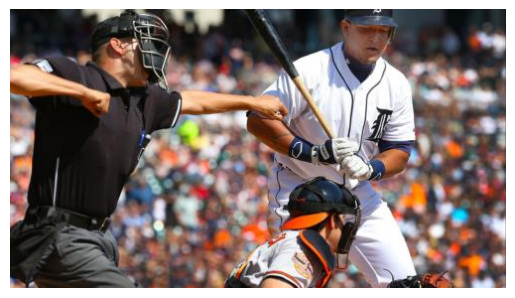

(281, 500, 3)

In [141]:
image1_path = "/kaggle/input/nptu-dl-final-project/train/00073f6b7b18474f9c3dad988137d743.jpg"
image1 = image.imread(image1_path)
plt.imshow(image1)
plt.axis(False)
plt.show()

image1.shape

# 模型訓練

In [182]:
EPOCHS = 30
CLS = 10
BSIZE = 256
LEARN_RATE = 0.001
L2 = 0.005

In [183]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 32,
                        kernel_size = (2, 2),
                        input_shape = (img_height, img_width, 3),
                        padding = 'same',
                        kernel_regularizer = l2(L2),
                        ))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(layers.MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 64,
                 kernel_size=(2,2),
                 padding='same',
                 kernel_regularizer = l2(L2),
                 ))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 128,
                 kernel_size=(2,2),
                 padding='same',
                 kernel_regularizer = l2(L2),
                ))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 256,
                 kernel_size=(2,2),
                 padding='same',
                 kernel_regularizer = l2(L2),
                ))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

# model.add(Dropout(0.25 , name = 'dropout_1'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.5, name = 'dropout_2'))
model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 224, 224, 32)      416       
                                                                 
 activation_48 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 112, 112, 64)      8256      
                                                                 
 activation_49 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                               

In [184]:
opt = Adam(learning_rate=0.005)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [185]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    epochs=10, validation_data=validation_generator, verbose = 1)

Epoch 1/10
379/379 [==============================] - 40s 102ms/step - loss: 4.3980 - accuracy: 0.0912 - val_loss: 3.7395 - val_accuracy: 0.1649
Epoch 2/10
379/379 [==============================] - 32s 83ms/step - loss: 3.6606 - accuracy: 0.1605 - val_loss: 3.3751 - val_accuracy: 0.2121
Epoch 3/10
379/379 [==============================] - 37s 98ms/step - loss: 3.3322 - accuracy: 0.2137 - val_loss: 3.1672 - val_accuracy: 0.2447
Epoch 4/10
379/379 [==============================] - 32s 85ms/step - loss: 3.0654 - accuracy: 0.2629 - val_loss: 3.0435 - val_accuracy: 0.2789
Epoch 5/10
379/379 [==============================] - 34s 90ms/step - loss: 2.8442 - accuracy: 0.3074 - val_loss: 2.8189 - val_accuracy: 0.3235
Epoch 6/10
379/379 [==============================] - 38s 100ms/step - loss: 2.6056 - accuracy: 0.3605 - val_loss: 2.7271 - val_accuracy: 0.3461
Epoch 7/10
379/379 [==============================] - 37s 98ms/step - loss: 2.3775 - accuracy: 0.4106 - val_loss: 2.7107 - val_accurac

In [186]:
model.evaluate(validation_generator)

95/95 [==============================] - 7s 76ms/step - loss: 2.7622 - accuracy: 0.3682


[2.762213706970215, 0.3682132363319397]

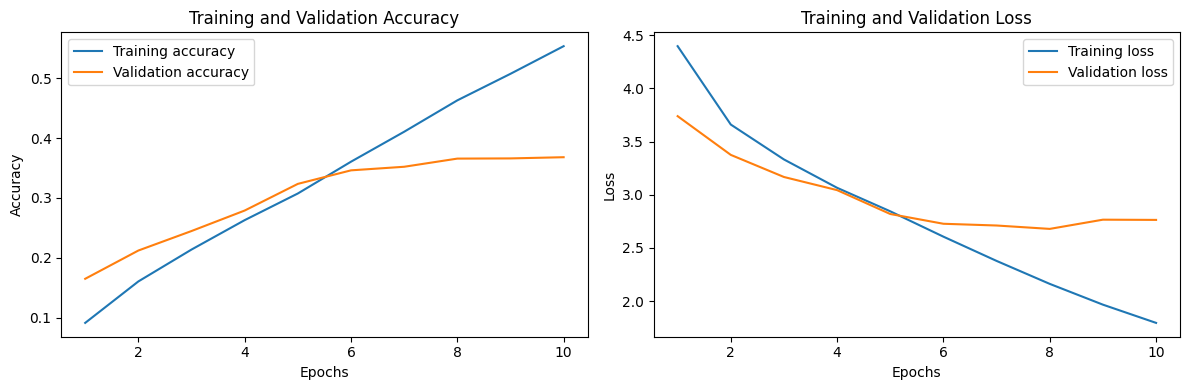

In [187]:
    # Extracting training and validation metrics from the history object
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plotting accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [188]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_path = "/kaggle/input/nptu-dl-final-project/test"
test_datagen = ImageDataGenerator(rescale=1./255)

# 獲取所有圖像文件名稱
test_filenames = [f for f in os.listdir(test_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# 創建 DataFrame
df_test = pd.DataFrame({
    'img_file': test_filenames,
    'label': ['unknown'] * len(test_filenames)  # 這裡的label隨意填寫，因為我們不會用到
})

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col='img_file',
    y_col=None,  # 沒有標籤
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode=None,  # 沒有標籤
    shuffle=False  # 保持文件順序
)

# 預測
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 獲取文件名
filenames = test_generator.filenames
filenames = [f.split('/')[-1] for f in filenames]  # 只保留文件名

print(len(predicted_classes))

Found 12436 validated image filenames.
389/389 [==============================] - 23s 60ms/step
12436


In [189]:
predicted_labels = [class_indices[int(k)] for k in predicted_classes]
results = pd.DataFrame({
    'img_file': test_filenames,
    'label': predicted_labels
})

# 保存到 .csv 文件
# results.to_csv('/kaggle/working/results.csv', index=False)
results.to_csv('/content/results.csv', index=False)

# 實驗結果的統計

## 第一次  loss: 6.2804, accuracy: 0.2349 kaggle: 0.24220

In [150]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 32,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 64,
#                  kernel_size=(2,2),
#                  padding='same',
#                  activation='relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters=128,
#                  kernel_size=(2,2),
#                  padding='same',
#                  activation='relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

In [151]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [152]:
# history = model.fit(train_generator,
#                     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#                     validation_steps=validation_generator.samples // validation_generator.batch_size,
#                     epochs=10, validation_data=validation_generator, verbose = 1)

## 第二次 loss: 4.3759  accuracy: 0.0342 kaggle: 0.03007

每一層針對 BatchNormalization() 進行處理

In [153]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 32,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 64,
#                  kernel_size=(2,2),
#                  padding='same',
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters=128,
#                  kernel_size=(2,2),
#                  padding='same',
#                 ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

## 第三次  loss: 3.8086 accuracy: 0.3300 kaggle: 0.31810

使用 Dropout 避免過度擬和

In [154]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 32,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 64,
#                  kernel_size=(2,2),
#                  padding='same',
#                  ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters=128,
#                  kernel_size=(2,2),
#                  padding='same',
#                 ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Dropout(0.25, name = 'dropout_1'))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(Dropout(0.5, name = 'dropout_2'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

# 第四次 loss: 3.4314 - accuracy: 0.2968

調整 fileter 數目

In [155]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 16,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 32,
#                  kernel_size=(2,2),
#                  padding='same',
#                  ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters=64,
#                  kernel_size=(2,2),
#                  padding='same',
#                 ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Dropout(0.25, name = 'dropout_1'))

# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(Dropout(0.5, name = 'dropout_2'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

# 第五次 loss: 4.1614 - accuracy: 0.3017 kaggle: 0.28706

調整 Adam 的設置 learning_rate=0.005 預設

In [156]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 16,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 32,
#                  kernel_size=(2,2),
#                  padding='same',
#                  ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters=64,
#                  kernel_size=(2,2),
#                  padding='same',
#                 ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Dropout(0.25, name = 'dropout_1'))

# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(Dropout(0.5, name = 'dropout_2'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

In [157]:
# opt = Adam(learning_rate=0.005)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 第六次 loss: 4.6227 accuracy: 0.2945 kaggle: 0.28642

調整 Dropout 均為 0.2

In [158]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 16,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# # model.add(keras.layers.BatchNormalization(momentum=0.99,epsilon=0.001))
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 32,
#                  kernel_size=(2,2),
#                  padding='same',
#                  ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters=64,
#                  kernel_size=(2,2),
#                  padding='same',
#                 ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Dropout(0.2, name = 'dropout_1'))

# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(Dropout(0.2, name = 'dropout_2'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

In [159]:
# opt = Adam(learning_rate=0.005)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 第七次 loss: 3.9848 accuracy: 0.3208 kaggle: 0.31055

每一層均使用 L2 正則化 0.005

In [160]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 32,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# # model.add(keras.layers.BatchNormalization(momentum=0.99,epsilon=0.001))
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 64,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                  ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 128,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Dropout(0.25 , name = 'dropout_1'))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(Dropout(0.25, name = 'dropout_2'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

# 第八次 loss: 3.8246 accuracy: 0.3304

調整回原本 filter 數目

In [160]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 32,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# # model.add(keras.layers.BatchNormalization(momentum=0.99,epsilon=0.001))
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 64,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                  ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 128,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Dropout(0.25 , name = 'dropout_1'))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(Dropout(0.25, name = 'dropout_2'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

# 第九次 loss: 3.1881 - accuracy: 0.3504

新增一層 Layer

In [ ]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 32,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# # model.add(keras.layers.BatchNormalization(momentum=0.99,epsilon=0.001))
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 64,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                  ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 128,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Conv2D(filters = 256,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Dropout(0.25 , name = 'dropout_1'))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(Dropout(0.25, name = 'dropout_2'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

# 第十次 loss: 2.7622 accuracy: 0.3682

使用一層 Dropout 且設定 0.5

In [ ]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 32,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 64,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                  ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 128,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Conv2D(filters = 256,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# # model.add(Dropout(0.25 , name = 'dropout_1'))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(Dropout(0.5, name = 'dropout_2'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()